In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from datetime import datetime
import optuna
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from optuna.samplers import TPESampler
import sqlalchemy
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, mean_squared_error,mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBClassifier
import optuna
from optuna.samplers import TPESampler
from sklearn.linear_model import Ridge  # 使用 Ridge 回归代替逻辑回归
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from optuna.samplers import RandomSampler, CmaEsSampler
from lightgbm import LGBMClassifier
import shap
import lime
import lime.lime_tabular

import joblib
import seaborn as sns
import import_ipynb

import sys
print(sys.executable)

C:\Users\Acer\anaconda3\envs\transformer_git\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\Acer\anaconda3\envs\transformer_git\python.exe


In [2]:
import sklearn, xgboost,lightgbm
print(sklearn.__version__,xgboost.__version__,lightgbm.__version__)

1.3.2 2.1.2 4.5.0


In [3]:
import numpy,shap
print(numpy.__version__,shap.__version__)

1.24.3 0.44.1


In [4]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示问题

In [5]:
num = 63
train = pd.read_csv(f'../train_test_data/data_final_train_{num}_features.csv')
test = pd.read_csv(f'../train_test_data/data_final_test_{num}_features.csv')

In [6]:
print(train.shape)
print(test.shape)
X_train = train.drop(columns='转化率_1')
X_test = test.drop(columns='转化率_1')
y_train = train['转化率_1'].copy()  # 创建副本
y_test = test['转化率_1'].copy()  # 创建副本

y_train[y_train <= 1] = 0
y_test[y_test <= 1] = 0

y_train[y_train >= 2] = 1
y_test[y_test >= 2] = 1

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(19640, 64)
(3544, 64)
(19640, 63) (19640,)
(3544, 63) (3544,)


In [7]:
def optuna_fit(objective,model_name,sqlite_db,study_name,n_trials=100,direction='maximize'):
#     Optuna 超参数优化

    study = optuna.create_study(
        storage=sqlite_db,
        study_name=study_name,
        sampler=RandomSampler(),
        direction=direction,
        load_if_exists=True
    )

    study.optimize(objective, n_trials)

    # 输出优化结果
    print(f"Best optimized accuracy: {study.best_value:.5f}")
    print(f"Best hyperparameters: {study.best_params}")

    best_params = study.best_params
    
    return best_params

def fit_model(model_name,best_params):

    model = model_name(**best_params)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # 输出分类报告和准确率
    print("分类报告：\n", classification_report(y_test, y_pred))
    print("准确率：", accuracy_score(y_test, y_pred))

    return model

In [8]:
def plot_feature_importances(model):
    # 提取特征重要性
    feature_importances = model.feature_importances_
    features = X_train.columns

    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)

    # 可视化特征重要性
    plt.figure(figsize=(10, 10))
    sns.barplot(
        data=importance_df, 
        x='Importance', 
        y='Feature', 
        hue = 'Feature',
        palette='viridis',
        legend=False  
    )
    
    model_name = type(model).__name__
    
    plt.title(f"{num}_Feature Importance - {model_name}")  # **动态添加模型名称**
    plt.tight_layout()

    save_path = f'../result_picture/{model_name}/{model_name}_{num}_features_importance.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Feature Importance 图像已保存至 {save_path}")
    
    plt.show()



# LIME 
def plot_lime(X_train,X_test,model,i):
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, mode='classification')

    exp = explainer.explain_instance(X_test.iloc[i].values, model.predict_proba, num_features=10)

    exp.show_in_notebook()

    model_name = type(model).__name__
    save_path = f'../result_picture/{model_name}/{model_name}_{num}_lime_explanation.html'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    exp.save_to_file(save_path)
    print(f"LIME 解释已保存至 {save_path}")
    
    
    
def plot_shap(model, X_test,max_display_num):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # 兼容不同模型
    if isinstance(shap_values, list):  # 二分类任务 (LGBM 和 RF 可能返回 list)
        shap_values = shap_values[1]  # 取正类 SHAP 值

    # 计算每个特征的平均 SHAP 绝对值
    shap_importance = np.abs(shap_values).mean(axis=0)

    # 找出 SHAP 贡献极小的特征
    low_importance_features = X_test.columns[shap_importance < 1e-5]
    if low_importance_features.tolist():
        print("SHAP 贡献极小的特征:", low_importance_features.tolist())
    
    model_name = type(model).__name__
    save_path = f'../result_picture/{model_name}/{model_name}_{num}_shap_explanation.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    plt.figure(figsize=(10, 10))
    
    shap.summary_plot(shap_values, X_test, max_display=max_display_num, show=False)
    
    plt.title(f"{num}_Feature SHAP_Explanation - {model_name}")  # **动态添加模型名称**
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"SHAP Summary 图像已保存至 {save_path}")
    
    plt.show()

In [4]:
# storage,study_name = 'sqlite:///voting.db', 'voting_xgb_rf_lgbm_44'

# storage_url = storage

# study_names = optuna.study.get_all_study_names(storage=storage_url)

# print(f"数据库中共有 {len(study_names)} 个 Study：")
# print(study_names)

# optuna.delete_study(study_name= study_name, storage=storage)
# study = optuna.load_study(study_name=study_name, storage=storage)
# df = study.trials_dataframe()
# df.sort_values(by='value',ascending=False)
# dict(df.sort_values(by='value',ascending=False).iloc[0])
# df

In [10]:
# storage,study_name = 'sqlite:///voting.db', 'voting_xgb_rf_lgbm'
# study = optuna.load_study(study_name=study_name, storage=storage)
# trials = study.get_trials()
# from datetime import datetime
# date_to_delete = '2025-02-26'
# date_to_delete = datetime.strptime(date_to_delete, '%Y-%m-%d')
# filtered_trials = [trial for trial in trials if trial.datetime_start.date() != date_to_delete.date()]


# new_study = optuna.create_study(study_name='voting_xgb_rf_lgbm_44', storage='sqlite:///voting.db', direction='maximize')


# for trial in filtered_trials:
#     new_study.add_trial(trial)

# XGB

In [11]:
def xgb_objective(trial):
    params = {
        'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
        'n_estimators': trial.suggest_int('n_estimators', 400, 2000),  # 增加 n_estimators 范围
        'learning_rate': trial.suggest_float('learning_rate', 0.006, 0.6, log=True),  # 降低学习率范围
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),  # 修改该范围
        'max_depth': trial.suggest_int('max_depth', 3, 15),  # 增加深度范围
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 100.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 100.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 5.0),  # 处理类别不平衡时有用  
    }

#   多分类参数
    params["booster"] = "gbtree"
#     params["objective"] = "multi:softmax"  # 多分类任务
#     params['num_class'] = len(y_train.unique())  # 自动设置类别数量    
    params["objective"] = "binary:logistic"  # 二分类
    params["tree_method"] = "hist"
    params["verbosity"] = 0  


#   交叉验证对象
    cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
#     for train_idx, val_idx in cv.split(X_train, y_train):
#         print(f"Train indices: {len(train_idx)}, Val indices: {len(val_idx)}")


    accuracy_scorer = make_scorer(accuracy_score)


    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=accuracy_scorer, n_jobs=-1)

    return scores.mean()

xgb_best_hyperparameters = optuna_fit(xgb_objective,XGBClassifier,'sqlite:///xgb.db',f'xgb_class_{num}_features',n_trials=1,direction='maximize')

[I 2025-03-12 22:18:24,482] Using an existing study with name 'xgb_class_63_features' instead of creating a new one.
[I 2025-03-12 22:18:58,002] Trial 110 finished with value: 0.8581466395112016 and parameters: {'grow_policy': 'lossguide', 'n_estimators': 1461, 'learning_rate': 0.12057787933497373, 'gamma': 0.3682926266242643, 'subsample': 0.7537328351416779, 'colsample_bytree': 0.8559181085225789, 'max_depth': 15, 'min_child_weight': 4, 'reg_lambda': 2.103620259024111e-06, 'reg_alpha': 0.00417668693413652, 'scale_pos_weight': 4.080466611789819}. Best is trial 92 with value: 0.8679735234215886.


Best optimized accuracy: 0.86797
Best hyperparameters: {'grow_policy': 'lossguide', 'n_estimators': 1891, 'learning_rate': 0.013118434279846818, 'gamma': 0.4525239662148137, 'subsample': 0.662585324824845, 'colsample_bytree': 0.7494049964621559, 'max_depth': 14, 'min_child_weight': 7, 'reg_lambda': 42.41110404971759, 'reg_alpha': 0.00035765675394731553, 'scale_pos_weight': 1.002465046208691}


In [12]:
XGB_model = fit_model(XGBClassifier,xgb_best_hyperparameters)

分类报告：
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      2267
           1       0.84      0.80      0.82      1277

    accuracy                           0.87      3544
   macro avg       0.86      0.86      0.86      3544
weighted avg       0.87      0.87      0.87      3544

准确率： 0.8718961625282167


Feature Importance 图像已保存至 ../result_picture/XGBClassifier/XGBClassifier_63_features_importance.png


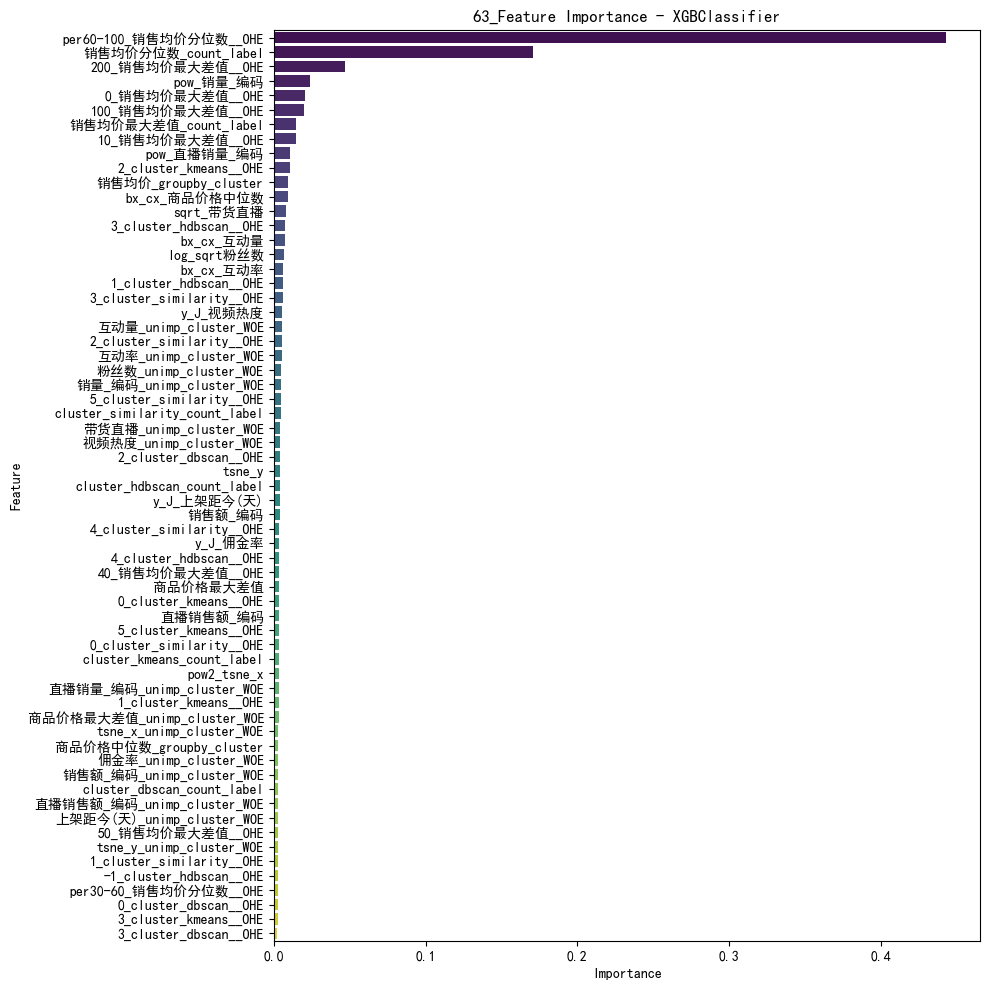

In [13]:
plot_feature_importances(XGB_model)

In [14]:
plot_lime(X_train,X_test,XGB_model,i = 1001)

LIME 解释已保存至 ../result_picture/XGBClassifier/XGBClassifier_63_lime_explanation.html


SHAP Summary 图像已保存至 ../result_picture/XGBClassifier/XGBClassifier_63_shap_explanation.png


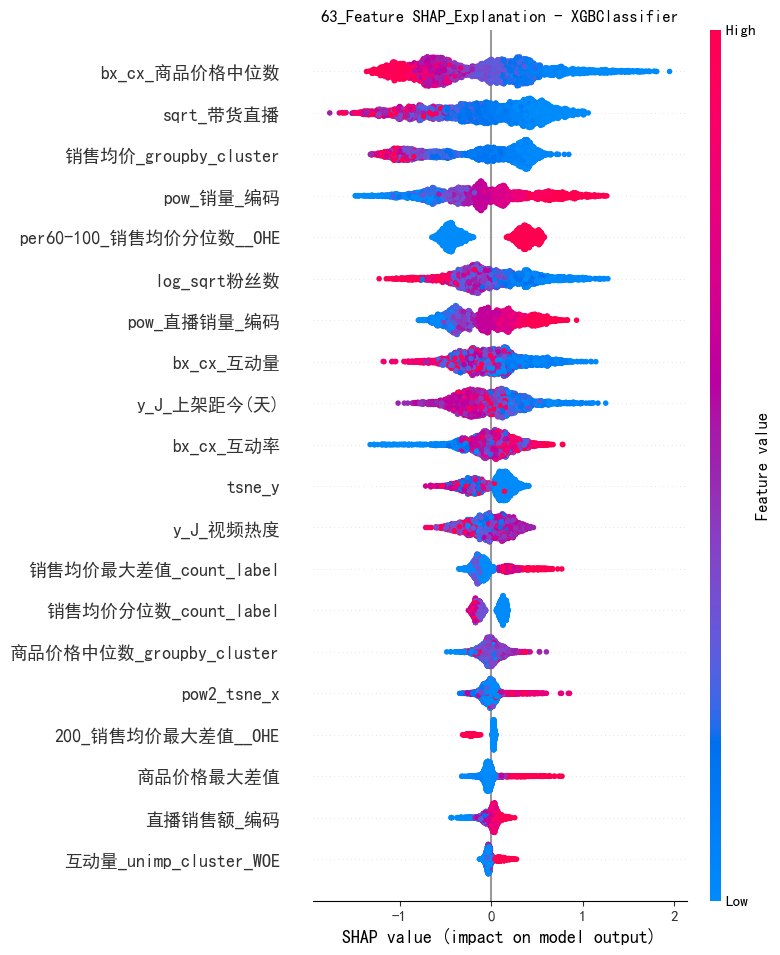

In [15]:
plot_shap(XGB_model,X_test,20)

# LGBM

In [16]:
from lightgbm import LGBMClassifier

def lgbm_objective(trial):
    params = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves': trial.suggest_int('num_leaves', 20, 400),  # 调整范围，避免太小导致 underfitting
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),  # 降低范围，防止过拟合
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),  # 增加范围，防止过拟合
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 0.5), 
        'metric': 'binary_error',
    }
    
    # 交叉验证（StratifiedKFold 保证类别均衡）
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    
    accuracy_scorer = make_scorer(accuracy_score)
    
    # LightGBM 二分类模型
    model = LGBMClassifier(**params, 
                           objective='binary', 
                           random_state=42
                           ,verbose=-1
                           )
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=accuracy_scorer, n_jobs=-1)

    return scores.mean()

lgbm_best_hyperparameters = optuna_fit(lgbm_objective,LGBMClassifier,'sqlite:///lgbm.db',f'lgbm_class_{num}_features',n_trials=1,direction='maximize')

[I 2025-03-12 22:21:31,165] Using an existing study with name 'lgbm_class_63_features' instead of creating a new one.
[I 2025-03-12 22:23:15,210] Trial 105 finished with value: 0.864867617107943 and parameters: {'boosting_type': 'dart', 'num_leaves': 279, 'learning_rate': 0.3209198258690567, 'n_estimators': 1557, 'subsample_for_bin': 58697, 'min_child_samples': 50, 'reg_alpha': 2.855852952662719, 'reg_lambda': 2.893205946800414e-07, 'colsample_bytree': 0.6259813541384935, 'subsample': 0.655816148542533, 'max_depth': 14, 'min_gain_to_split': 0.14350951883380691}. Best is trial 48 with value: 0.8677698574338086.


Best optimized accuracy: 0.86777
Best hyperparameters: {'boosting_type': 'dart', 'num_leaves': 246, 'learning_rate': 0.12595864617336103, 'n_estimators': 1772, 'subsample_for_bin': 268373, 'min_child_samples': 12, 'reg_alpha': 0.025083202248968022, 'reg_lambda': 0.16202781808390979, 'colsample_bytree': 0.7262520195964558, 'subsample': 0.9737339978773515, 'max_depth': 12, 'min_gain_to_split': 0.216272796825761}


In [17]:
lgbm_best_hyperparameters.setdefault('verbose', -1)
LGBM_model = fit_model(LGBMClassifier,lgbm_best_hyperparameters)

分类报告：
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      2267
           1       0.84      0.79      0.81      1277

    accuracy                           0.87      3544
   macro avg       0.86      0.85      0.86      3544
weighted avg       0.87      0.87      0.87      3544

准确率： 0.8702031602708804


Feature Importance 图像已保存至 ../result_picture/LGBMClassifier/LGBMClassifier_63_features_importance.png


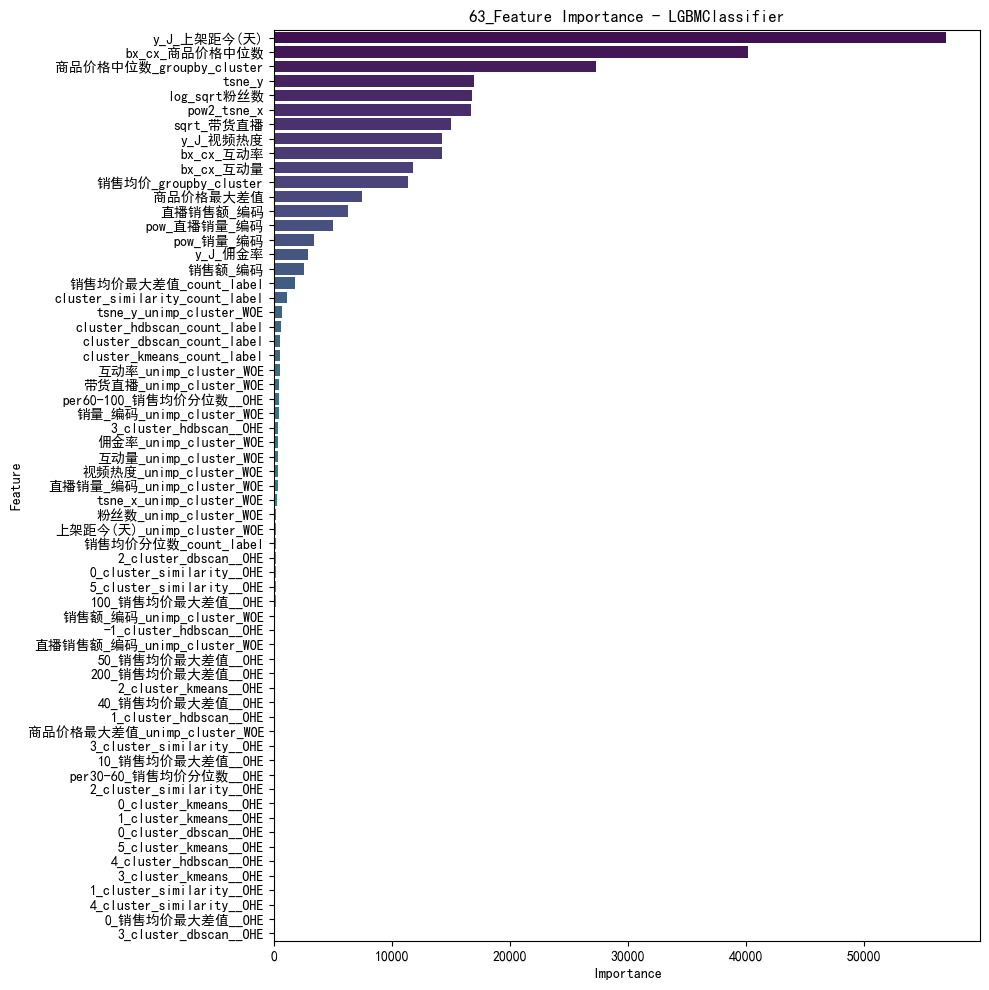

In [18]:
plot_feature_importances(LGBM_model)

In [19]:
plot_lime(X_train,X_test,LGBM_model,i = 2000)

LIME 解释已保存至 ../result_picture/LGBMClassifier/LGBMClassifier_63_lime_explanation.html


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


SHAP 贡献极小的特征: ['3_cluster_dbscan__OHE']
SHAP Summary 图像已保存至 ../result_picture/LGBMClassifier/LGBMClassifier_63_shap_explanation.png


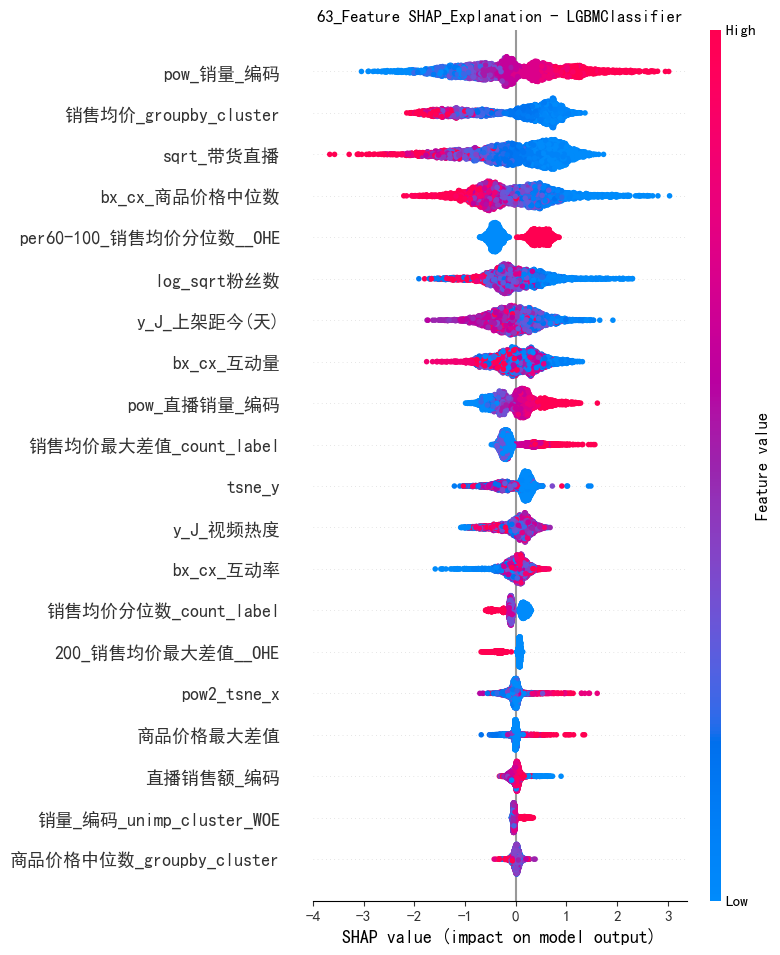

In [20]:
plot_shap(LGBM_model,X_test,20)

# 随机森林

In [21]:
def df_objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),  # 决策树数量
        'max_depth': trial.suggest_int('max_depth', 2, 20),  # 树的最大深度
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),  # 最小分割样本数
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),  # 叶节点最少样本数
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),  # 特征选择方式
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),  # 切分标准
        'max_samples': trial.suggest_float('max_samples', 0.5, 1.0),  # 每棵树的样本数
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),  # 类别不平衡处理
        'warm_start': trial.suggest_categorical('warm_start', [True, False]),  # 是否重用前次计算的树
    }


    # 交叉验证对象
    cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

    # 评分器
    accuracy_scorer = make_scorer(accuracy_score)


    model = RandomForestClassifier(random_state=42, **params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=accuracy_scorer, n_jobs=-1)

    return scores.mean()


rf_best_hyperparameters = optuna_fit(df_objective,RandomForestClassifier,'sqlite:///rf.db',f'rf_class_{num}_features',n_trials=1,direction='maximize')

[I 2025-03-12 22:26:00,821] Using an existing study with name 'rf_class_63_features' instead of creating a new one.
[I 2025-03-12 22:26:34,089] Trial 102 finished with value: 0.859826883910387 and parameters: {'n_estimators': 484, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy', 'max_samples': 0.8151628092330365, 'class_weight': None, 'warm_start': True}. Best is trial 74 with value: 0.860183299389002.


Best optimized accuracy: 0.86018
Best hyperparameters: {'n_estimators': 859, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'criterion': 'entropy', 'max_samples': 0.73683035225184, 'class_weight': None, 'warm_start': False}


In [22]:
RF_model = fit_model(RandomForestClassifier,rf_best_hyperparameters)

分类报告：
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      2267
           1       0.84      0.78      0.81      1277

    accuracy                           0.87      3544
   macro avg       0.86      0.85      0.86      3544
weighted avg       0.87      0.87      0.87      3544

准确率： 0.8687923250564334


Feature Importance 图像已保存至 ../result_picture/RandomForestClassifier/RandomForestClassifier_63_features_importance.png


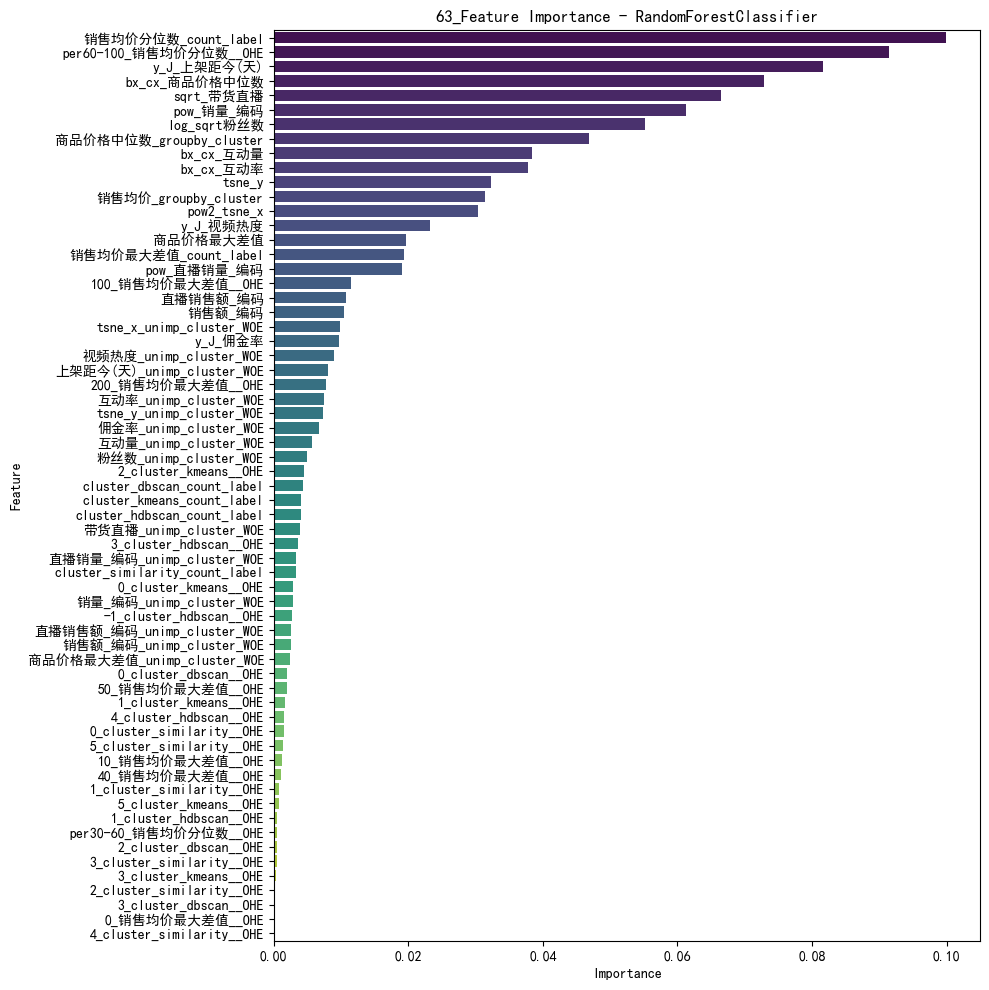

In [23]:
plot_feature_importances(RF_model)

In [24]:
plot_lime(X_train,X_test,RF_model,i = 2000)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


LIME 解释已保存至 ../result_picture/RandomForestClassifier/RandomForestClassifier_63_lime_explanation.html


In [25]:
# plot_shap(RF_model,X_test,20)

# 集成学习

In [26]:
from sklearn.ensemble import  VotingClassifier
# 定义 VotingClassifier 的目标函数
def voting_objective(trial):
    # 搜索投票方式（hard/soft）
#     voting_type = trial.suggest_categorical("voting", ["soft"])
    
    # XGBoost 的超参数
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 400, 2000),
        'learning_rate': trial.suggest_float('xgb_learning_rate', 0.006, 0.6, log=True),
        'gamma': trial.suggest_float('xgb_gamma', 0, 0.5),
        'subsample': trial.suggest_float('xgb_subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.3, 1.0),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('xgb_min_child_weight', 1, 10),
        'reg_lambda': trial.suggest_float('xgb_reg_lambda', 1e-9, 100.0, log=True),
        'reg_alpha': trial.suggest_float('xgb_reg_alpha', 1e-9, 100.0, log=True),
        'scale_pos_weight': trial.suggest_float('xgb_scale_pos_weight', 1.0, 5.0),
        'tree_method': 'hist',
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'verbosity': 0
    }

    
    # LightGBM 超参数
    lgbm_params = {
        'boosting_type': trial.suggest_categorical('lgbm_boosting_type', ['gbdt', 'dart']),
        'num_leaves': trial.suggest_int('lgbm_num_leaves', 20, 400),
        'learning_rate': trial.suggest_float('lgbm_learning_rate', 0.001, 0.5, log=True),
        'n_estimators': trial.suggest_int('lgbm_n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('lgbm_min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('lgbm_reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('lgbm_reg_lambda', 1e-9, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('lgbm_colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('lgbm_subsample', 0.6, 1.0),
        'max_depth': trial.suggest_int('lgbm_max_depth', 3, 15),
        'min_gain_to_split': trial.suggest_float('lgbm_min_gain_to_split', 0.0, 0.5),
        'objective': 'binary',
        'metric': 'binary_error',
        'verbose': -1,
        'random_state': 42
    }
    
    # RandomForest 的超参数
    rf_params = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('rf_max_depth', 2, 20),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('rf_max_features', ['sqrt', 'log2', None]),
        'criterion': trial.suggest_categorical('rf_criterion', ['gini', 'entropy']),
        'max_samples': trial.suggest_float('rf_max_samples', 0.5, 1.0),
        'class_weight': trial.suggest_categorical('rf_class_weight', [None, 'balanced']),
        'warm_start': trial.suggest_categorical('rf_warm_start', [True, False]),
        'random_state': 42
    }
    

    # 设定权重
    xgb_weight = trial.suggest_float("xgb_weight", 0.1, 0.7)
    rf_weight = trial.suggest_float("rf_weight", 0.1, 0.7)
    lgbm_weight = 1.0 - (xgb_weight + rf_weight)  # 确保权重和为 1
    
    if lgbm_weight <= 0:
        return 0  # 让 Optuna 忽略这个超参数组合


    cv_estimators = [
        ('xgboost', XGBClassifier(**xgb_params)),
        ('rf', RandomForestClassifier(**rf_params)),
        ('lgbm', LGBMClassifier(**lgbm_params)),
    ]
    
    # 创建 VotingClassifier
    voting_clf = VotingClassifier(
        estimators=cv_estimators,
        voting='soft',
        weights=[xgb_weight, rf_weight, lgbm_weight],
        n_jobs=-1
    )

    # 交叉验证
    cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
    accuracy_scorer = make_scorer(accuracy_score)
    scores = cross_val_score(voting_clf, X_train, y_train, cv=cv, scoring=accuracy_scorer, n_jobs=-1)

    return scores.mean()


# 运行 Optuna 进行超参数搜索
Voting_best_hyperparameters = optuna_fit(voting_objective, VotingClassifier, 'sqlite:///voting.db', f'voting_xgb_rf_lgbm_{num}', n_trials=1, direction='maximize')


[I 2025-03-12 22:30:18,346] Using an existing study with name 'voting_xgb_rf_lgbm_63' instead of creating a new one.
[I 2025-03-12 22:35:32,947] Trial 102 finished with value: 0.8632892057026478 and parameters: {'xgb_n_estimators': 1007, 'xgb_learning_rate': 0.014680829576805382, 'xgb_gamma': 0.3894307498581071, 'xgb_subsample': 0.8920790119121541, 'xgb_colsample_bytree': 0.5669835523062652, 'xgb_max_depth': 7, 'xgb_min_child_weight': 6, 'xgb_reg_lambda': 1.9051885246321896e-05, 'xgb_reg_alpha': 3.139517063608873e-08, 'xgb_scale_pos_weight': 2.6067413043073984, 'lgbm_boosting_type': 'dart', 'lgbm_num_leaves': 267, 'lgbm_learning_rate': 0.2452543992117931, 'lgbm_n_estimators': 1777, 'lgbm_min_child_samples': 79, 'lgbm_reg_alpha': 0.0020210103925739653, 'lgbm_reg_lambda': 0.029998220172008566, 'lgbm_colsample_bytree': 0.5618301062601524, 'lgbm_subsample': 0.6333928619527806, 'lgbm_max_depth': 10, 'lgbm_min_gain_to_split': 0.3946149825989338, 'rf_n_estimators': 521, 'rf_max_depth': 9, 'rf

Best optimized accuracy: 0.86741
Best hyperparameters: {'xgb_n_estimators': 833, 'xgb_learning_rate': 0.008981863968312237, 'xgb_gamma': 0.369777063788298, 'xgb_subsample': 0.6607313962780004, 'xgb_colsample_bytree': 0.32971471807609903, 'xgb_max_depth': 11, 'xgb_min_child_weight': 10, 'xgb_reg_lambda': 5.800514569719403e-09, 'xgb_reg_alpha': 1.7025010944929342e-06, 'xgb_scale_pos_weight': 1.762497321595323, 'lgbm_boosting_type': 'dart', 'lgbm_num_leaves': 137, 'lgbm_learning_rate': 0.3357516599054941, 'lgbm_n_estimators': 494, 'lgbm_min_child_samples': 8, 'lgbm_reg_alpha': 0.0001969112862475773, 'lgbm_reg_lambda': 6.640969959250482e-09, 'lgbm_colsample_bytree': 0.8456569997963863, 'lgbm_subsample': 0.6685143643320463, 'lgbm_max_depth': 10, 'lgbm_min_gain_to_split': 0.36897522504895985, 'rf_n_estimators': 131, 'rf_max_depth': 6, 'rf_min_samples_split': 19, 'rf_min_samples_leaf': 17, 'rf_max_features': None, 'rf_criterion': 'entropy', 'rf_max_samples': 0.6878010802925212, 'rf_class_weig

In [27]:
def fit_voting_model(Voting_best_hyperparameters):
    # 解析最佳参数
    best_params = Voting_best_hyperparameters.copy()

    # 解析模型权重
    xgb_weight = best_params.pop("xgb_weight")
    rf_weight = best_params.pop("rf_weight")
    lgbm_weight = 1.0 - (xgb_weight + rf_weight)  # 确保权重和为 1

    # 确保 LGBM 权重合法
    if lgbm_weight <= 0:
        raise ValueError("LGBM weight calculated as <= 0. Check Voting_best_hyperparameters.")

    # 分离 XGBoost、RandomForest 和 LightGBM 参数
    xgb_params = {k.replace("xgb_", ""): v for k, v in best_params.items() if k.startswith("xgb_")}
    rf_params = {k.replace("rf_", ""): v for k, v in best_params.items() if k.startswith("rf_")}
    lgbm_params = {k.replace("lgbm_", ""): v for k, v in best_params.items() if k.startswith("lgbm_")}

    print("XGBoost Parameters:", xgb_params,"xgb_weight",xgb_weight)
    print("RandomForest Parameters:", rf_params,"rf_weight",rf_weight)
    print("LightGBM Parameters:", lgbm_params,"lgbm_weight",lgbm_weight)

    # 初始化单个模型
    xgb = XGBClassifier(**xgb_params)
    rf = RandomForestClassifier(**rf_params)
    lgbm = LGBMClassifier(**lgbm_params)

    # 创建 VotingClassifier
    voting_model = VotingClassifier(
        estimators=[('xgboost', xgb), ('rf', rf), ('lgbm', lgbm)],
        voting='soft',
        weights=[xgb_weight, rf_weight, lgbm_weight],
        n_jobs=-1
    )

    # 训练 VotingClassifier
    voting_model.fit(X_train, y_train)
    
    y_pred = voting_model.predict(X_test)

    # 输出分类报告和准确率
    print("分类报告：\n", classification_report(y_test, y_pred))
    print("准确率：", accuracy_score(y_test, y_pred))

    return voting_model

# 训练 Voting 模型
Voting_model = fit_voting_model(Voting_best_hyperparameters)

XGBoost Parameters: {'n_estimators': 833, 'learning_rate': 0.008981863968312237, 'gamma': 0.369777063788298, 'subsample': 0.6607313962780004, 'colsample_bytree': 0.32971471807609903, 'max_depth': 11, 'min_child_weight': 10, 'reg_lambda': 5.800514569719403e-09, 'reg_alpha': 1.7025010944929342e-06, 'scale_pos_weight': 1.762497321595323} xgb_weight 0.4059504297124473
RandomForest Parameters: {'n_estimators': 131, 'max_depth': 6, 'min_samples_split': 19, 'min_samples_leaf': 17, 'max_features': None, 'criterion': 'entropy', 'max_samples': 0.6878010802925212, 'class_weight': None, 'warm_start': False} rf_weight 0.26845656841276433
LightGBM Parameters: {'boosting_type': 'dart', 'num_leaves': 137, 'learning_rate': 0.3357516599054941, 'n_estimators': 494, 'min_child_samples': 8, 'reg_alpha': 0.0001969112862475773, 'reg_lambda': 6.640969959250482e-09, 'colsample_bytree': 0.8456569997963863, 'subsample': 0.6685143643320463, 'max_depth': 10, 'min_gain_to_split': 0.36897522504895985} lgbm_weight 0.

Feature Importance 图像已保存至 ../result_picture/VotingClassifier/VotingClassifier_63_features_importance.png


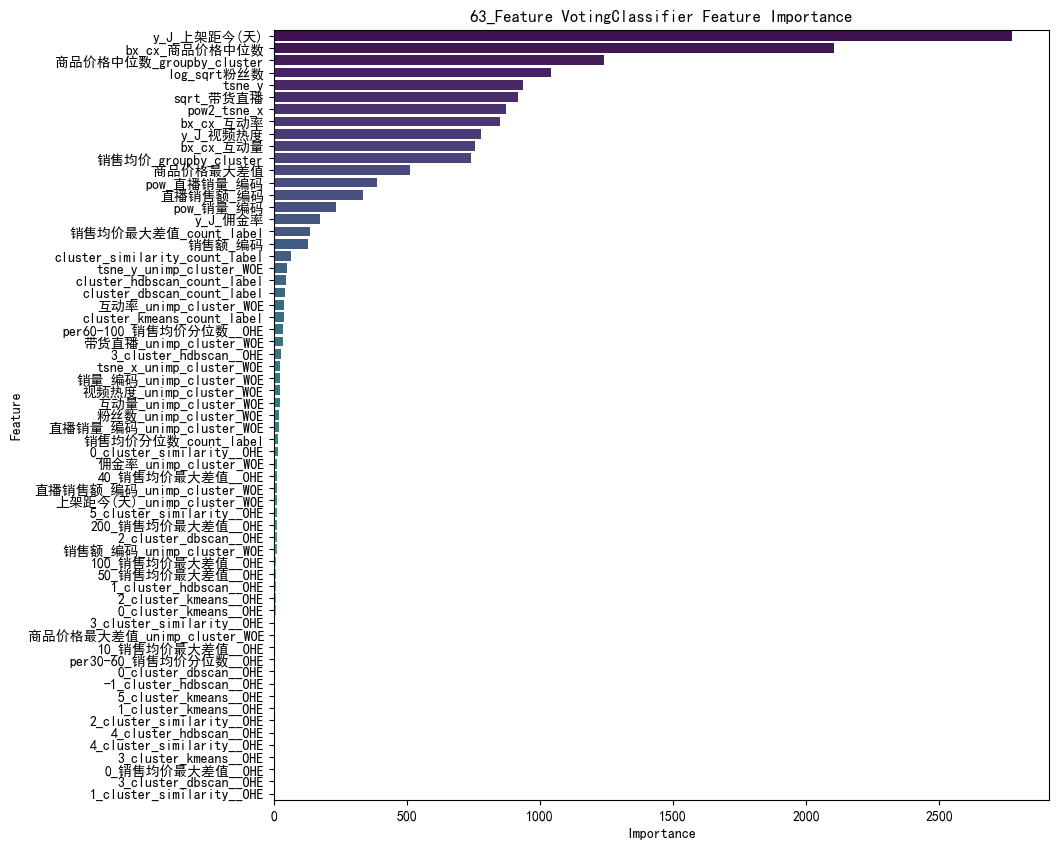

In [28]:
def plot_importance_features(voting_model,Voting_best_hyperparameters):    
# 提取子模型
    best_params = Voting_best_hyperparameters.copy()
    
    xgb_weight = best_params.pop("xgb_weight")
    rf_weight = best_params.pop("rf_weight")
    lgbm_weight = 1.0 - (xgb_weight + rf_weight)  # 确保权重和为 1
    
    xgb_model = voting_model.named_estimators_["xgboost"]
    rf_model = voting_model.named_estimators_["rf"]
    lgbm_model = voting_model.named_estimators_["lgbm"]

    # 提取特征重要性
    xgb_importance = xgb_model.feature_importances_
    rf_importance = rf_model.feature_importances_
    lgbm_importance = lgbm_model.feature_importances_

    # 获取特征名称
    features = X_train.columns

    # 计算综合特征重要性（加权平均）
    weighted_importance = (
        (xgb_importance * xgb_weight) + 
        (rf_importance * rf_weight) + 
        (lgbm_importance * lgbm_weight)
    )

    # 创建 DataFrame
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': weighted_importance
    }).sort_values(by='Importance', ascending=False)

    # 可视化特征重要性
    plt.figure(figsize=(10, 10))
    sns.barplot(
        data=importance_df, 
        x='Importance', 
        y='Feature', 
        hue = 'Feature',
        palette='viridis'
    )
    plt.title(f"{num}_Feature VotingClassifier Feature Importance")
    
    model_name = type(voting_model).__name__
    
    save_path = f'../result_picture/{model_name}/{model_name}_{num}_features_importance.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Feature Importance 图像已保存至 {save_path}")
    
    plt.show()
    
plot_importance_features(Voting_model,Voting_best_hyperparameters)

In [29]:
plot_lime(X_train,X_test,Voting_model,i = 1001)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


LIME 解释已保存至 ../result_picture/VotingClassifier/VotingClassifier_63_lime_explanation.html


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


SHAP Summary 图像已保存至 ../result_picture/VotingClassifier/VotingClassifier_63_shap_explanation.png


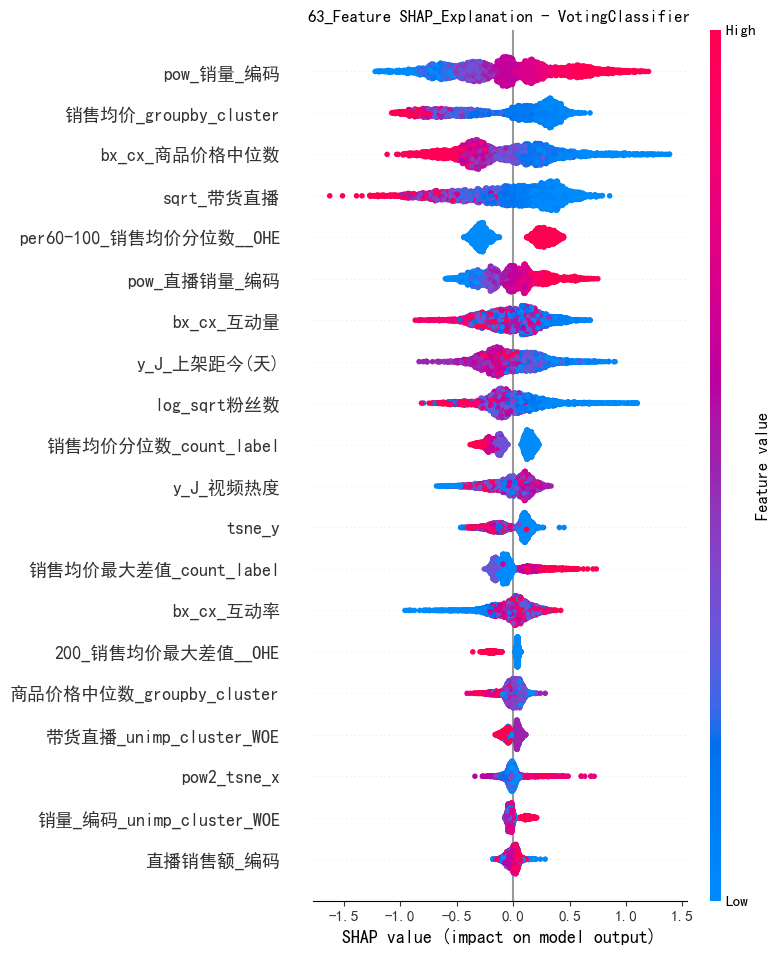

In [30]:
def plot_shap(voting_model, X_test,max_display_num):

    xgb_model = voting_model.named_estimators_["xgboost"]
    rf_model = voting_model.named_estimators_["rf"]
    lgbm_model = voting_model.named_estimators_["lgbm"]

    xgb_explainer = shap.TreeExplainer(xgb_model)
    xgb_shap_values = xgb_explainer.shap_values(X_test)

    # 计算 SHAP 值（RandomForest），禁用 additivity 检查
    rf_explainer = shap.TreeExplainer(rf_model)
    rf_shap_values = rf_explainer.shap_values(X_test, check_additivity=False)


    lgbm_explainer = shap.TreeExplainer(lgbm_model)
    lgbm_shap_values = lgbm_explainer.shap_values(X_test)

    # 解析 VotingClassifier 权重
    xgb_weight = voting_model.weights[0]
    rf_weight = voting_model.weights[1]
    lgbm_weight = voting_model.weights[2]

    # 处理 SHAP 值格式
    if isinstance(xgb_shap_values, list):  
        xgb_shap_values = np.array(xgb_shap_values[1])  # 取正类 SHAP

    if isinstance(rf_shap_values, list):  
        rf_shap_values = np.array(rf_shap_values[1])  # 取正类 SHAP

    if isinstance(lgbm_shap_values, list):  
        lgbm_shap_values = np.array(lgbm_shap_values[1])  # 取正类 SHAP

    # 计算 SHAP 加权平均（综合 VotingClassifier 权重）
    weighted_shap_values = (
        (xgb_shap_values * xgb_weight) + 
        (rf_shap_values * rf_weight) + 
        (lgbm_shap_values * lgbm_weight)
    )

    # 创建 SHAP Explanation 结构，确保兼容 summary_plot
    shap_exp = shap.Explanation(
        values=weighted_shap_values,
        base_values=np.mean(weighted_shap_values, axis=0),
        data=X_test
    )


    model_name = type(voting_model).__name__
    save_path = f'../result_picture/{model_name}/{model_name}_{num}_shap_explanation.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    plt.figure(figsize=(10, 10))
    
    shap.summary_plot(shap_exp, X_test,max_display=max_display_num, show=False)
    
    plt.title(f"{num}_Feature SHAP_Explanation - {model_name}")  # **动态添加模型名称**
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"SHAP Summary 图像已保存至 {save_path}")
    plt.show()
    

plot_shap(Voting_model, X_test,20)


In [28]:
for model in [XGB_model,LGBM_model,RF_model,Voting_model]:
    model_name = type(model).__name__
    print(model_name)
    save_path = f'..\model\{model_name}\{model_name}_for_{num}_features.pkl'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    joblib.dump(model, save_path)
# voting_model_load = joblib.load("voting_model.pkl")

XGBClassifier
LGBMClassifier
RandomForestClassifier
VotingClassifier
